# Gmail analysis
### Exploring more than 13 years of Gmail messages

I learned recently that Google allows its users to download metadata for all the messages sent and received through Gmail. This leads to interesting insights to be found in the data: *What are the most common people I have been in touch with? What days of the week or time of the day have the highest trafic?* In order to explore these and other questions I decided to request my data and perform the present analysis.

The first step is [requesting the data](https://takeout.google.com/settings/takeout). There is data available for several Google services, only the Gmail data is used here. Depending on the amount of data the request can take several hours (my file is 8.2GB). Once we notified that the file is ready to be downloaded, the data will come in a special format called `mailbox`. After importing some useful modules we can explore and clean the data.

In [1]:
import mailbox
import pandas as pd
import csv
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})
#import dateparser

from time import time

## 1. Data preprocessing
We begin the analysis by saving the data file `gmail_data.mbox` in a directory called `data` (for privacy reasons, this file is absent from the Github repository). The file can be loaded using the `mailbox` module

In [2]:
dir_path = 'data/'
filename = 'gmail_data.mbox'
file_path = dir_path + filename
mbox = mailbox.mbox(file_path)
print('samples:', len(mbox))

samples: 69988


The file contains 69,988 samples. Even though these are mostly email messages, many other entry types are counted, such as drafts and chats. These can be removed by filtering by Gmail label. The file contains the following labels

In [3]:
# print labels
for i, key in enumerate(mbox[0].keys()):
    print(i+1, key)

1 X-GM-THRID
2 X-Gmail-Labels
3 MIME-Version
4 Received
5 Date
6 Delivered-To
7 Message-ID
8 Subject
9 From
10 To
11 Content-Type


We find that there are several section of little interest. In order to avoid loading unnecessary information, we can extract the fields of interest and put them into a `pandas` dataframe for further processing. We are interested in the following fields: `subject`, `from`, `to`, `date`, and `Gmail-label`.

In [8]:
t0 = time()
subject = []
from_ = []
to = []
date = []
label = []
for i, message in enumerate(mbox):
    try:
        if i%2000 == 0:
            print(i, end=' ')
        subject.append(message['subject'])
        from_.append(message['from'])
        to.append(message['to'])
        date.append(message['date'])
        label.append(message['X-Gmail-Labels'])
    except:
        print(i, end=' ')
        print('subject', subject[i])
        print('from', from_[i])
        print('to', to[i])
        print('date', date[i])
        print('label', label[i])
print('\ntime: {:.1f} min'.format((time()-t0)/60))

In [11]:
df = pd.DataFrame()
df['subject'] = subject
df['from'] = from_
df['to'] = to
df['date'] = date
df['label'] = label

In [19]:
df[['subject', 'date', 'label']].head()

,subject,date,label
0,consulta DS,"Tue, 8 Aug 2017 11:20:05 +0200","Important,Sent"
1,Re: consulta DS,"Tue, 08 Aug 2017 10:35:39 +0100","Important,Inbox"
2,Re: consulta DS,"Tue, 08 Aug 2017 10:43:30 +0100","Important,Inbox"
3,Re: consulta DS,"Tue, 8 Aug 2017 13:16:37 +0200",Sent
4,NaN,"Sun, 19 Nov 2017 14:28:18 +0100","Important,Inbox"


My Gmail data contains mostly messages in English; however, there is plenty of Spanish and German, which introduce special characters that can lead to encoding issues. For this reason, it is better to encode special characters such as `ñ` and letters with accents and umlauts

In [ ]:
def remove_accents(text):
    text = str(text)
    nfkd_norm = unicodedata.normalize('NFKD', text)
    text = nfkd_norm.encode('ASCII', 'ignore').decode('utf-8')
    return text

In [ ]:
df['subject'] = df['subject'].map(remove_accents)

After cleaning the `subject` field, we can get a general overview of the integrity of different fields

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69988 entries, 0 to 69987
Data columns (total 5 columns):
subject    66828 non-null object
from       69988 non-null object
to         55762 non-null object
date       56735 non-null object
label      69604 non-null object
dtypes: object(5)
memory usage: 2.7+ MB


We find that `date`, one of the most relevant fields, contains many null entries (mostly from chat entries)

In [29]:
df[df['date'].isnull()][['subject', 'to', 'date']].head()

,subject,to,date,label
16,None,NaN,NaN,Chat
26,None,NaN,NaN,Chat
90,None,NaN,NaN,Chat
91,None,NaN,NaN,Chat
92,None,NaN,NaN,Chat


The total number of null entries is

In [31]:
len(df[df['date'].isnull()])

56735

All these entries can be removed

In [32]:
# delete null rows
df = df[df['date'].notnull()]

In [33]:
len(df)

56735

We can now focus on the `date` field. The next goal is to transform the class type: dates are given as strings

In [34]:
df[['date']].head()

,date
0,"Tue, 8 Aug 2017 11:20:05 +0200"
1,"Tue, 08 Aug 2017 10:35:39 +0100"
2,"Tue, 08 Aug 2017 10:43:30 +0100"
3,"Tue, 8 Aug 2017 13:16:37 +0200"
4,"Sun, 19 Nov 2017 14:28:18 +0100"


These string dates can be converted into timestamps using the converted available for dataframes

In [7]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

Some dates have unappropriate shape for conversion (these are drafts of spam messages), which can be simply removed

In [23]:
df = df[df['date'].notnull()]

Given that the date is now a timestamp, messages can be easily sorted by date, after which the dataframe index must be reset

In [27]:
df = df.sort_values(['date'], ascending=False)
df = df.reset_index(drop=True)

The most recent messages are the following

In [9]:
df[['subject', 'date', 'label']].head(8)

,subject,date,label
0,Your Google data archive is ready,2018-01-27 18:30:32+00:00,"Important,Inbox"
1,None,2018-01-27 17:48:17+00:00,"Important,Jan"
2,NaN,2018-01-27 17:17:36+00:00,Drafts
3,NaN,2018-01-27 10:21:42+00:00,"Unread,old_stuff/_KIT,Spam"
4,easy loan to obtain,2018-01-26 20:36:15+00:00,"Unread,Spam"
5,=?utf-8?Q?The=20Support=20Your=20Student=20Bod...,2018-01-26 20:24:02+00:00,"Unread,Spam"
6,None,2018-01-26 18:59:24+00:00,"Important,Jan"
7,"aantonop: ""Bitcoin Q&A: Layered scaling and pr...",2018-01-26 17:47:20+00:00,Trash


where the most recent message is the notification from Gmail to download the data used here. The oldest messages are

In [11]:
df[['subject', 'date', 'label']].tail(9)

,subject,date,label
51986,Re: Asamblea,2004-10-05 14:21:47+00:00,Inbox
51987,Asamblea,2004-10-05 12:55:58+00:00,Inbox
51988,None,2004-10-01 22:06:10+00:00,Inbox
51989,NaN,2004-09-29 18:24:55+00:00,Sent
51990,Web del teste para el cambio (fwd),2004-09-27 19:43:40+00:00,Inbox
51991,=?ISO-8859-1?B?SW5mb3JtYWNp824=?=\n\tSegunda E...,2004-09-27 16:42:58+00:00,Inbox
51992,de dayton,2004-09-14 23:29:03+00:00,Inbox
51993,Escuela del CERN,2004-09-14 14:58:38+00:00,Inbox
51994,NaN,2004-09-10 17:03:41+00:00,Inbox


At this point, and given the time used for cleaning the data file, it is a good idea to export it as a `csv` file for future use without the need of redoing the preprocessing above.

In [33]:
df.to_csv('data/gmail_data_preprocessed.csv', 
          encoding='utf-8', index=False)

## 2. Data exploration

We can now begin exploring the data set.

In [71]:
df = pd.read_csv('data/gmail_data_preprocessed.csv')
len(df)

51995

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51995 entries, 0 to 51994
Data columns (total 5 columns):
subject    48853 non-null object
from       51995 non-null object
to         51026 non-null object
date       51995 non-null object
label      51876 non-null object
dtypes: object(5)
memory usage: 2.0+ MB


Since the data was loaded from a `csv` file, the dates are back as `str` so they must be converted into `timestamp` again

In [73]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

In [74]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [75]:
dow, day = [], []
for i in range(len(df)):
    try:
        dow.append(df['date'][i].weekday())
        day.append(days[dow[i]])
    except:
        print(i)

In [76]:
len(dow), len(day), len(df)

(51995, 51995, 51995)

Create new `series` with the day of the week of the message

In [77]:
df['dow'] = dow
df['day'] = day
df[['subject', 'date', 'dow', 'day', 'label']].head(8)

,subject,date,dow,day,label
0,Your Google data archive is ready,2018-01-27 18:30:32+00:00,5,Saturday,"Important,Inbox"
1,None,2018-01-27 17:48:17+00:00,5,Saturday,"Important,Jan"
2,NaN,2018-01-27 17:17:36+00:00,5,Saturday,Drafts
3,NaN,2018-01-27 10:21:42+00:00,5,Saturday,"Unread,old_stuff/_KIT,Spam"
4,easy loan to obtain,2018-01-26 20:36:15+00:00,4,Friday,"Unread,Spam"
5,=?utf-8?Q?The=20Support=20Your=20Student=20Bod...,2018-01-26 20:24:02+00:00,4,Friday,"Unread,Spam"
6,None,2018-01-26 18:59:24+00:00,4,Friday,"Important,Jan"
7,"aantonop: ""Bitcoin Q&A: Layered scaling and pr...",2018-01-26 17:47:20+00:00,4,Friday,Trash


We can now get the distribution of messages per day of the week

In [78]:
df['day'].value_counts()

Wednesday    9370
Monday       9362
Tuesday      9115
Thursday     8708
Friday       8120
Sunday       3813
Saturday     3507
Name: day, dtype: int64

In [79]:
def rename(txt, set_to_rename, new_name):
    txt = str(txt)
    for name in set_to_rename:
        if name in txt.lower():
            txt_out = new_name
            break
        else:
            txt_out = txt
    return txt_out

In [80]:
amazon = set(['amazon.de', 'amazon.com'])

In [81]:
df['to'] = df['to'].apply(lambda x: rename(x, jsd, 'me'))
df['to'] = df['to'].apply(lambda x: rename(x, mjc, 'Cote'))
df['to'] = df['to'].apply(lambda x: rename(x, vak, 'Alan K.'))
df['to'] = df['to'].apply(lambda x: rename(x, juan, 'Juan M.'))
df['to'] = df['to'].apply(lambda x: rename(x, crm, 'Cristian M.'))
df['to'] = df['to'].apply(lambda x: rename(x, rob, 'Roberto L.'))

In [82]:
df['to'].value_counts()[1:6]

Cote           5348
Alan K.        1696
nan             969
Juan M.         579
Cristian M.     503
Name: to, dtype: int64

This shows `nan`

In [83]:
df = df[df['to'] != 'nan']

In [84]:
df['to'].value_counts()[1:6]

Cote           5348
Alan K.        1696
Juan M.         579
Cristian M.     503
Roberto L.      422
Name: to, dtype: int64

In [85]:
df['from'] = df['from'].apply(lambda x: rename(x, jsd, 'me'))
df['from'] = df['from'].apply(lambda x: rename(x, mjc, 'Cote'))
df['from'] = df['from'].apply(lambda x: rename(x, vak, 'Alan K.'))
df['from'] = df['from'].apply(lambda x: rename(x, amazon, 'Amazon.com'))
df['from'] = df['from'].apply(lambda x: rename(x, juan, 'Juan M.'))
df['from'] = df['from'].apply(lambda x: rename(x, crm, 'Cristian M.'))
df['from'] = df['from'].apply(lambda x: rename(x, rob, 'Roberto L.'))

In [86]:
df['from'].value_counts()[1:7]

Cote           5996
Alan K.        1733
Amazon.com     1202
Cristian M.     654
Juan M.         508
Roberto L.      461
Name: from, dtype: int64

In [87]:
for name in ['Alan K.']:
    print('from', name + ':', len(df[df['from'] == name]))
    print('to  ', name + ':', len(df[df['to'] == name]))

from Alan K.: 1733
to   Alan K.: 1696


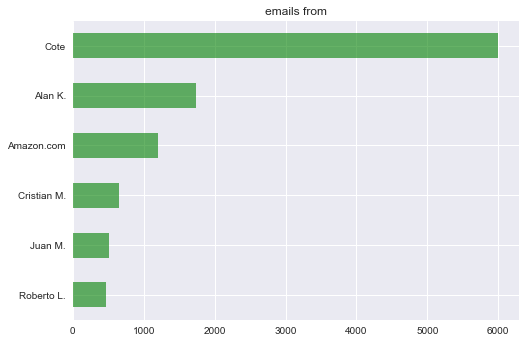

In [88]:
df['from'].value_counts()[1:7].plot(kind='barh', color='g', alpha=0.6).invert_yaxis()
plt.title('emails from');

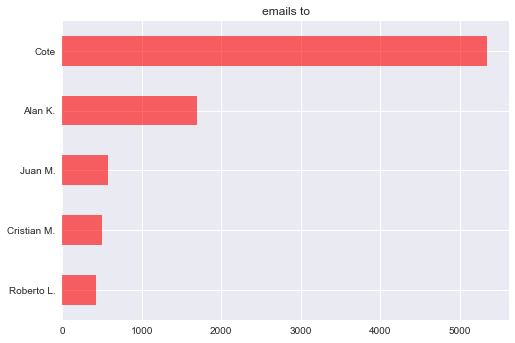

In [89]:
df['to'].value_counts()[1:6].plot(kind='barh', color='r', alpha=0.6).invert_yaxis()
plt.title('emails to');

In [50]:
from collections import Counter

In [51]:
count = Counter(df['from'])

In [52]:
count.most_common(7)

[('me', 17959),
 ('Cote', 5996),
 ('Alan K.', 1733),
 ('Amazon.com', 1202),
 ('Cristian M.', 654),
 ('Juan M.', 508),
 ('Roberto L.', 461)]

In [53]:
count['me']

17959

In [198]:
name = 'Cote'# 'Alan K.'
mess_from = df[['date']][df['from'] == name]
mess_to = df[['date']][df['to'] == name]

In [199]:
mess_from.set_index('date', drop=False, inplace=True)
mess_to.set_index('date', drop=False, inplace=True)

In [200]:
counts_to = [1 for _ in range(len(mess_to))]
counts_from = [1 for _ in range(len(mess_from))]
mess_to['counts'] = counts_to
mess_from['counts'] = counts_from

In [201]:
del mess_from['date']
del mess_to['date']

C:\Users\jsdiaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
C:\Users\jsdiaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  


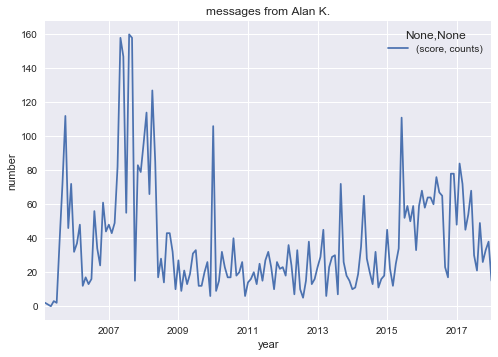

In [202]:
b = mess_from.resample('M').apply({'score':'count'})
c = mess_to.resample('M').apply({'score':'count'})
b.plot(label='')
plt.title('messages from Alan K.')
plt.ylabel('number')
plt.xlabel('year');
# c.plot();

In [158]:
x = list(b['score'])

In [159]:
x

['counts']

In [145]:
import numpy as np